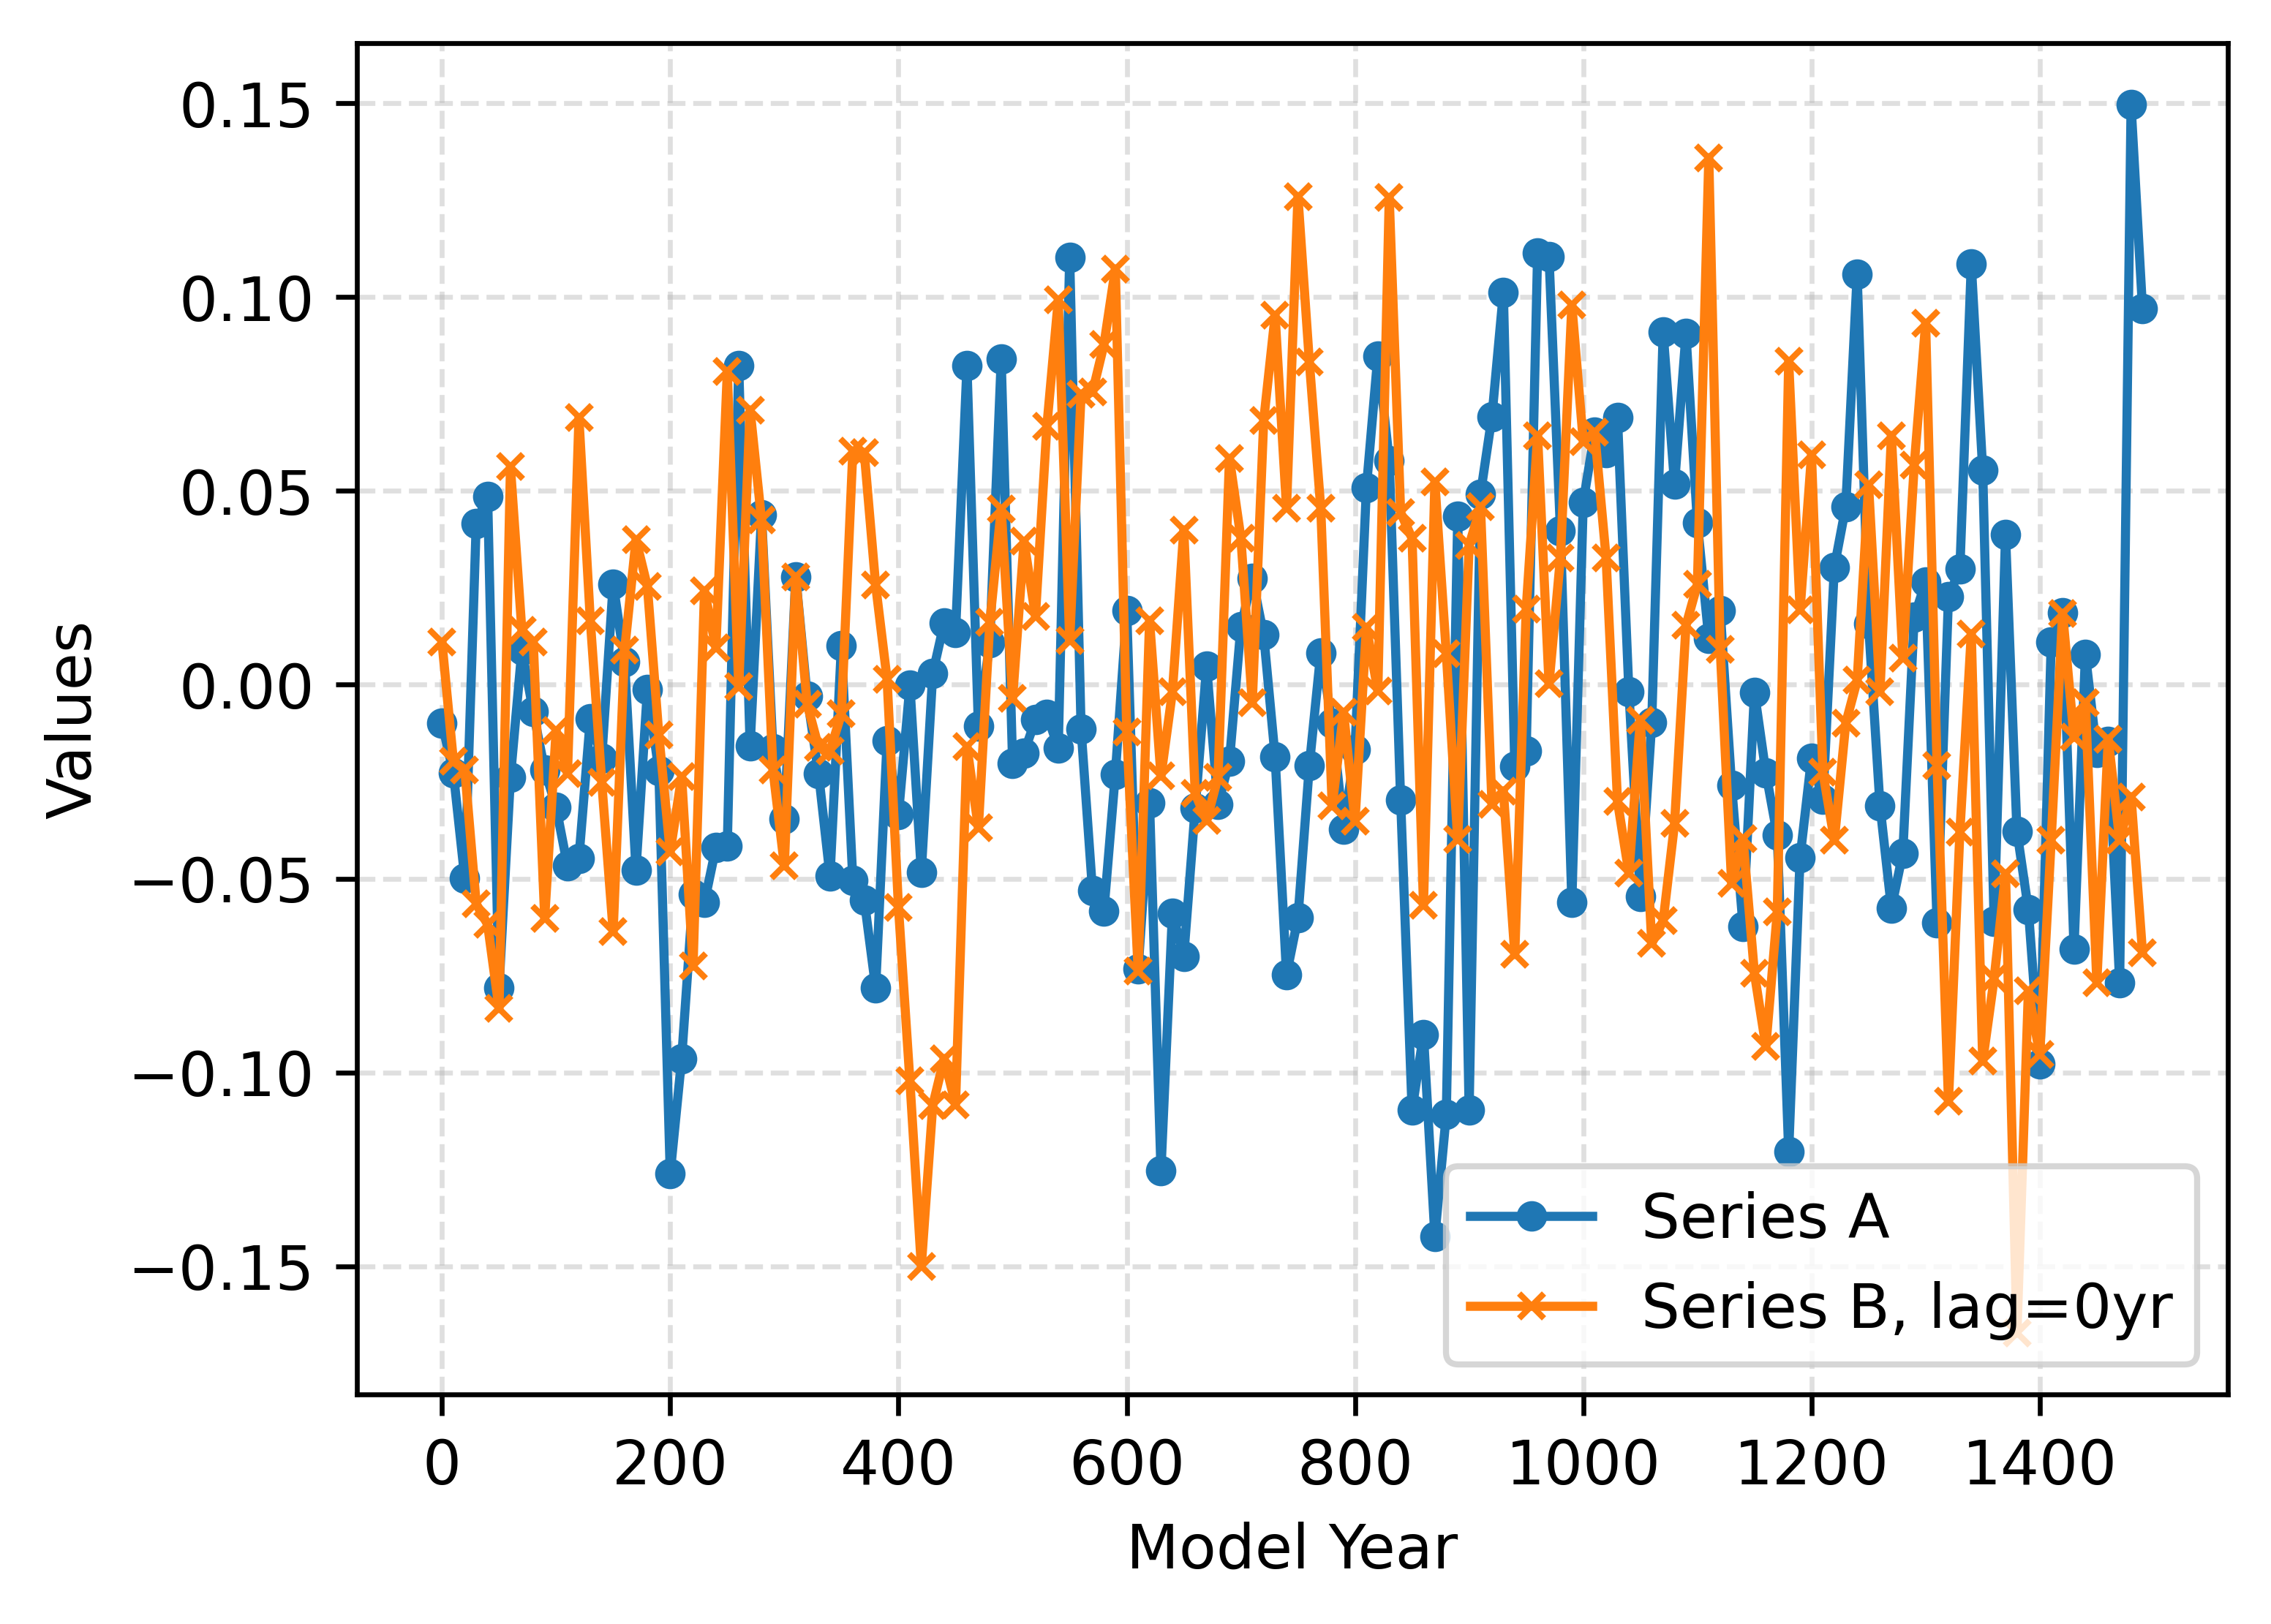

In [1]:
import matplotlib.pyplot as plt
from toolbox import syth_ana_functions as saf
import importlib
importlib.reload(saf)

lag=0
# data = gen_bi_directional_data(length=1500, delta=10, lag=lag, t0=800.0, dt=50.0, dy=1.0, GS_slope=5e-4, GIS_slope=-1e-3, tau=13.649751415738818, beta=0.3, sigma=0.05)
data = saf.gen_independent_data(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, phi=1e-2, sigma=0.05)
# data = gen_bi_directional_data(length=1500, delta=10.0, lag=-3, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=0.3, gamma=0.3, sigma=0.05)


# Enhance the plot
plt.figure(figsize=(5.5, 4),dpi=600)  # Adjust the figure size
plt.plot(data['time'], data['A'], label='Series A', linestyle='-', marker='o', markersize=4)
plt.plot(data['time'], data['B'], label=f'Series B, lag={lag*-10}yr', linestyle='-', marker='x', markersize=4)

# Add grid, title, and labels
plt.grid(True, linestyle='--', alpha=0.4)
# plt.title('Time Series of Dummy Warming Data')
plt.xlabel('Model Year')
plt.ylabel('Values')

# Add legend
plt.legend()

plt.show()

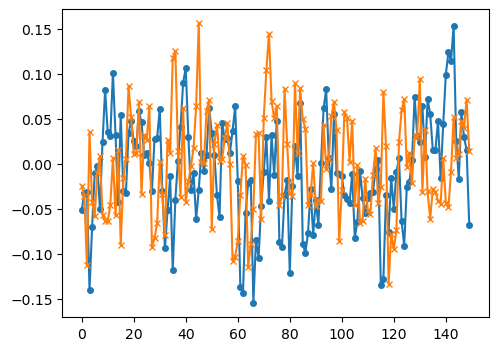

In [2]:
import numpy as np
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module
from toolbox import syth_ana_functions as saf
import importlib
importlib.reload(saf)
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn

ParCorr = parcorr.ParCorr(significance='analytic')


# Initialize parameters
# beta = np.arange(0.1, 1.1, 0.1)  # From 0.1 to 1.0 in steps of 0.1
phi = np.arange(1e-3, 1e-2+1e-3, 1e-3)  # From 0.1 to 1.0 in steps of 0.1
lags = 0
iterations = 100
causal_AB_results = np.zeros((len(phi)))
causal_BA_results = np.zeros((len(phi)))

causal_AB_true_count_all = np.zeros((len(phi)))
causal_BA_true_count_all = np.zeros((len(phi)))

# Loop through combinations of causal strengths and lags
h=0
for i, strength in enumerate(phi):
        
    causal_AB_true_count = 0
    causal_BA_true_count = 0
    
    for _ in range(iterations):
        # Generate dummy data and linked data
        # print (f'beta: {beta}, lag: {-lag}')
        data = saf.gen_independent_data(length=1500, delta=10.0, lag=-lag, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, phi=strength, sigma=0.05)
        # dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
        # dummy_warming_lagged = gen_linked_data(dummy_data, causal_strength=strength, delta=10.0, lag=lag, tau=13.649751415738818, sigma=0.06633234778696487)
        
        df_gc = data[['A', 'B']]

        if h == 0:
            plt.figure(figsize=(5.5, 4),dpi=100)
            plt.plot(df_gc['A'], label='Series A', linestyle='-', marker='o', markersize=4)
            plt.plot(df_gc['B'], label='Series B', linestyle='-', marker='x', markersize=4)

        h=h+1
        
        # df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
        # gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19, print_results=False)
        # causal_AB = gc_results_A_B[0]['XY']
        # causal_BA = gc_results_A_B[0]['YX']


        df_checked = GC.make_stationary(data,['A', 'B'], test_method='ADF', plot=False)
        AB_array = df_checked[['A', 'B']].values

        var_names=['A', 'B']
        # Create a Tigramite DataFrame object
        dataframe_sta = pp.DataFrame(AB_array,
                                datatime=np.arange(len(AB_array)),
                                var_names=var_names)


        tau_max=lag+1
        pcmci = PCMCI(
        dataframe=dataframe_sta,
        cond_ind_test=ParCorr,
        verbosity=1)

        pcmci.verbosity = 0
        results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)

        p_matrix = results['p_matrix']
        alpha_level = 0.05

        result = saf.get_link_direction(p_matrix, alpha_level)
        
        causal_AB = result[0]
        causal_BA = result[1]


        
        if causal_AB:
            causal_AB_true_count += 1
        if causal_BA:
            causal_BA_true_count += 1
    
    # Calculate the percentages
    causal_AB_results[i] = causal_AB_true_count / iterations
    causal_BA_results[i] = causal_BA_true_count / iterations

    causal_AB_results[i]  = causal_AB_results[i]  >= 0.95
    causal_BA_results[i] = causal_BA_results[i] >= 0.95
    
    causal_AB_true_count_all[i] = causal_AB_true_count
    causal_BA_true_count_all[i] = causal_BA_true_count




causal_results_red_nozscore = np.where((causal_AB_results == 0) & (causal_BA_results == 0), 0, 1)



In [6]:
# save the results to D:\VScode\Paleoclimate_causality\syth_test_results
import numpy as np

np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_AB_results_inde_PCMCI.npy', causal_AB_results)
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_BA_results_inde_PCMCI.npy', causal_BA_results)
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_results_red_nozscore_inde_PCMCI.npy', causal_results_red_nozscore)
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_AB_true_count_all_inde_PCMCI.npy', causal_AB_true_count_all)
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_BA_true_count_all_inde_PCMCI.npy', causal_BA_true_count_all)

In [8]:
# Load the results
import numpy as np

causal_AB_results = np.load('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_AB_results_inde_PCMCI.npy')
causal_BA_results = np.load('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_BA_results_inde_PCMCI.npy')
causal_results_red_nozscore = np.load('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_results_red_nozscore_inde_PCMCI.npy')
causal_AB_true_count_all = np.load('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_AB_true_count_all_inde_PCMCI.npy')
causal_BA_true_count_all = np.load('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_BA_true_count_all_inde_PCMCI.npy')

In [101]:
causal_results_red_nozscore

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

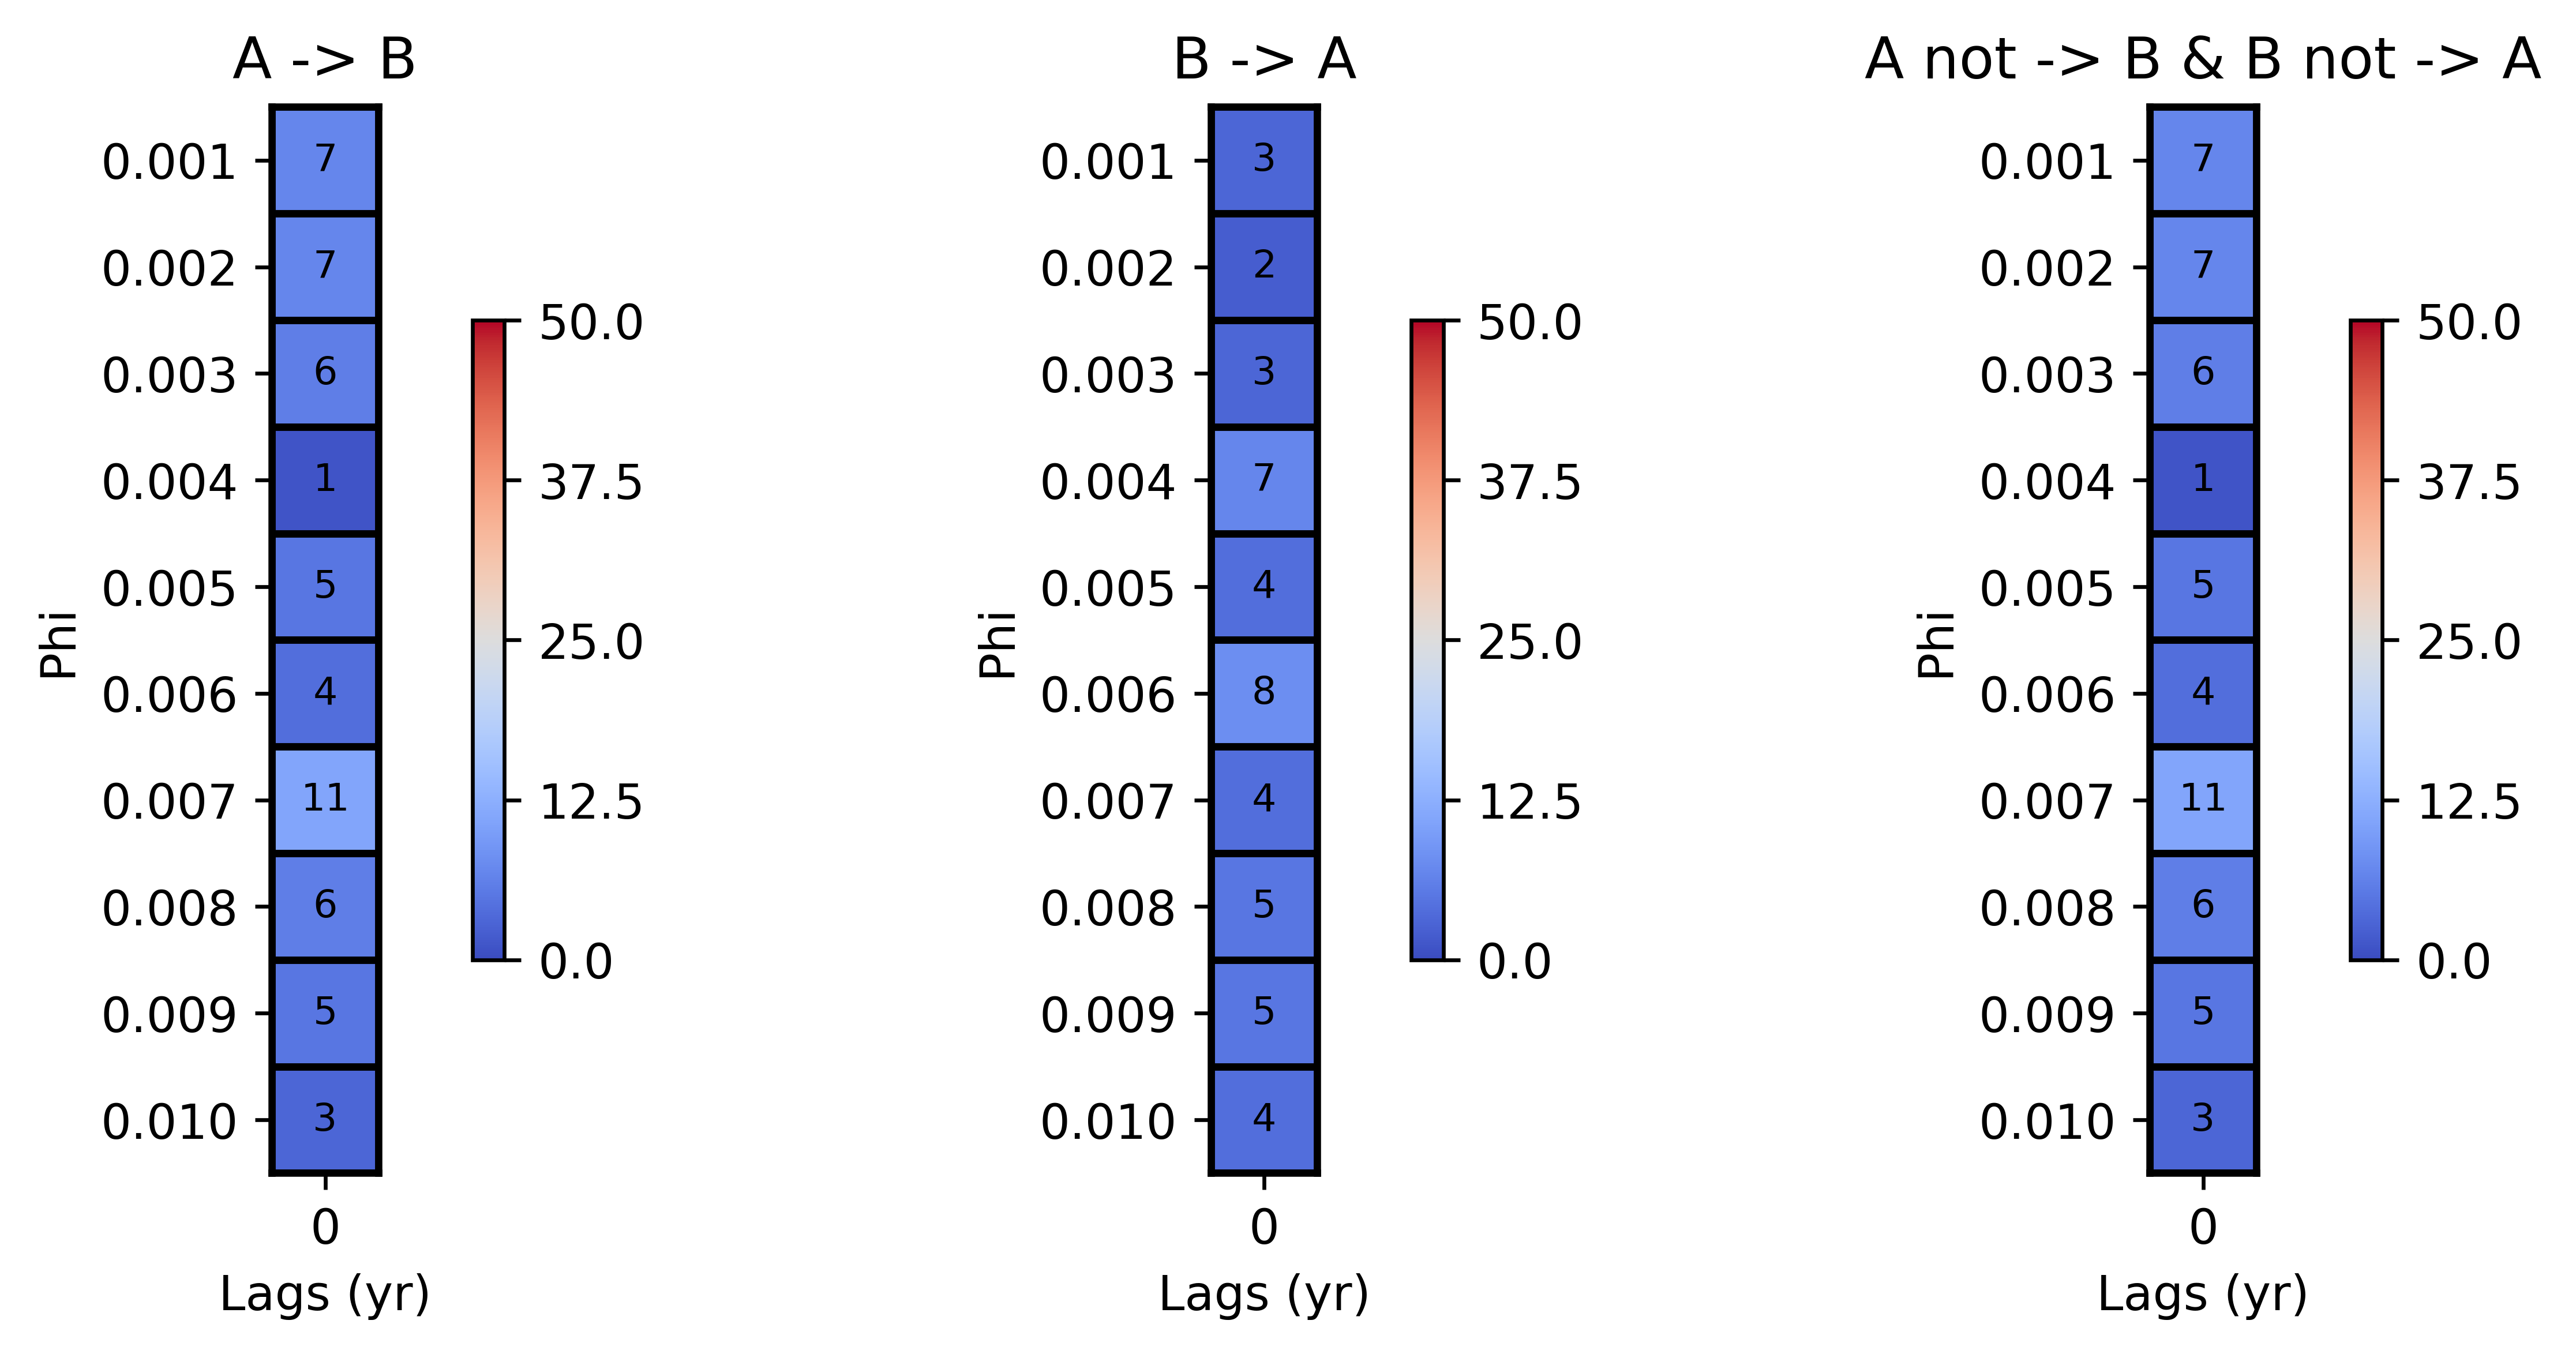

In [9]:
from toolbox import syth_ana_functions as saf
import matplotlib.pyplot as plt
import importlib    
importlib.reload(saf)

phi = np.arange(1e-3, 1e-2+1e-3, 1e-3)  
lags = 0
X=np.array(lags)
Y=np.array(phi)



fig, axs = plt.subplots(1, 3, figsize=(14,4), dpi=600)  # 1 row, 3 columns of plots

# Plot each of the causal matrices with text annotations
saf.causal_colormap_ax_1d(causal_AB_results, causal_AB_true_count_all, axs[0], X=X, Y=Y, title='A -> B', ylabel='Phi',show_counts=True, cmap='coolwarm', vmin=0, vmax=50)
saf.causal_colormap_ax_1d(causal_BA_results, causal_BA_true_count_all, axs[1], X=X, Y=Y, title='B -> A', ylabel='Phi',show_counts=True, cmap='coolwarm', vmin=0, vmax=50)

# create AB_BA_count, and if causal_results_red_nozscore is 1, set the value in AB_BA count to the value from the causal_AB_true_count_all
AB_BA_count = np.zeros((len(phi)))
for i in range(len(phi)):
    if causal_results_red_nozscore[i] == 0:
        AB_BA_count[i] = causal_AB_true_count_all[i]
    else:
        AB_BA_count[i] = np.nan


# Assuming causal_results_red_nozscore is derived in your existing code
saf.causal_colormap_ax_1d(causal_results=causal_results_red_nozscore, counts=AB_BA_count, ax=axs[2], X=X, Y=Y, title='A not -> B & B not -> A', ylabel='Phi',show_counts=True, cmap='coolwarm', vmin=0, vmax=50, box_linewidth=1.5)
# plt.tight_layout()
# adjust the horizontal space between the plots
plt.subplots_adjust(wspace=-0.5)
plt.show()